In [1]:
import os
import boto3
import re
import sagemaker
import random

role = sagemaker.get_execution_role()
region = boto3.Session().region_name

bucket = sagemaker.Session().default_bucket()

In [2]:
prefix = 'sagemaker/xgboost-nyc-trip'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region, bucket)

In [3]:
s3_client = boto3.client('s3')
Bytes_range = "bytes=0-1000"

src_bucket = 'trip-ny-test'
file_key = 'train/3cb0ea6a-4525-470f-b385-a949d77c047f.csv'

response = s3_client.get_object(Bucket=src_bucket,Key=file_key, Range=Bytes_range)
contents = response['Body'].read().decode('utf-8') 
print(contents)

"day_of_week","day_of_year","pickup_date","hour","minute","trip_count","trip_duration_min","passenger_count","trip_distance","pickup_locationid","pickup_zone","pickup_borough","total_amount","fare_amount","is_fog","is_rain","is_snow","tmax","tmin","prcp"
"7","181","2019-06-30","18","10","1","19.95","1","5.3","232","""Two Bridges/Seward Park""","""Manhattan""","26.75","19.0","0","0","0","85","71","0.02"
"1","14","2019-01-14","0","30","2","12.033333333333333","3","3.89","209","""Seaport""","""Manhattan""","19.6","16.0","0","0","0","35","22","0.0"
"1","14","2019-01-14","3","0","1","5.7","1","1.35","88","""Financial District South""","""Manhattan""","8.3","7.0","0","0","0","35","22","0.0"
"1","14","2019-01-14","3","30","1","3.4833333333333334","1","0.69","80","""East Williamsburg""","""Brooklyn""","5.8","4.5","0","0","0","35","22","0.0"
"1","14","2019-01-14","4","20","1","15.85","1","9.0","236","""Upper East Side North""","""Manhattan""","39.06","25.5","0","0","0","35","22","0.0"
"5","193"

In [4]:
import pandas as pd
s3_path = "s3://" + src_bucket + "/" + file_key

In [5]:
print(s3_path)

s3://trip-ny-test/train/3cb0ea6a-4525-470f-b385-a949d77c047f.csv


In [8]:
df_all = pd.read_csv(s3_path, header=0 )

In [7]:
!pip install s3fs

  Using cached s3fs-0.4.2-py3-none-any.whl (19 kB)


In [61]:
cols=list(df_all.columns.values)
print(cols)

['day_of_week', 'day_of_year', 'pickup_date', 'hour', 'minute', 'trip_count', 'trip_duration_min', 'passenger_count', 'trip_distance', 'pickup_locationid', 'pickup_zone', 'pickup_borough', 'total_amount', 'fare_amount', 'is_fog', 'is_rain', 'is_snow', 'tmax', 'tmin', 'prcp']


In [9]:
df_all.drop(['pickup_date','trip_duration_min','passenger_count','trip_distance','pickup_zone','pickup_borough','total_amount','trip_count','is_rain','is_snow'],axis=1,inplace=True)


In [11]:
df_all = df_all[['fare_amount', 'day_of_week', 'day_of_year', 'hour', 'minute',  'pickup_locationid',  'is_fog',  'tmax', 'tmin', 'prcp']]

In [12]:
df_small = df_all.sample(int(1e2))
df_small

,fare_amount,day_of_week,day_of_year,hour,minute,pickup_locationid,is_fog,tmax,tmin,prcp
10546879,18.5,2,148,10,0,261,1,71,62,0.19
7897851,120.0,3,65,19,40,90,0,27,19,0.00
6734145,161.5,4,150,22,30,148,1,68,56,0.80
980250,115.5,5,137,23,30,48,0,78,63,0.03
9330945,3.0,3,86,21,0,163,0,44,34,0.00
...,...,...,...,...,...,...,...,...,...,...
11487173,8.0,4,227,3,0,107,0,85,72,0.00
9405950,5.5,4,157,10,10,13,1,83,71,0.05
1588759,33.0,4,122,8,10,4,1,71,47,0.00
8228807,21.0,7,132,11,30,75,1,59,44,1.22


In [13]:
df_all.describe()

,fare_amount,day_of_week,day_of_year,hour,minute,pickup_locationid,is_fog,tmax,tmin,prcp
count,1.213806e+07,1.213806e+07,1.213806e+07,1.213806e+07,1.213806e+07,1.213806e+07,1.213806e+07,1.213806e+07,1.213806e+07,1.213806e+07
mean,9.038184e+01,4.056473e+00,1.776289e+02,1.247012e+01,2.498167e+01,1.504552e+02,3.249350e-01,6.281552e+01,4.911028e+01,1.385896e-01
std,3.323237e+02,1.989206e+00,1.054075e+02,6.626911e+00,1.708988e+01,7.319390e+01,4.683506e-01,1.880070e+01,1.714468e+01,3.186654e-01
min,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.600000e+01,3.000000e+00,0.000000e+00
25%,1.550000e+01,2.000000e+00,8.600000e+01,7.000000e+00,1.000000e+01,9.000000e+01,0.000000e+00,4.600000e+01,3.500000e+01,0.000000e+00
50%,4.100000e+01,4.000000e+00,1.740000e+02,1.300000e+01,2.000000e+01,1.470000e+02,0.000000e+00,6.300000e+01,4.900000e+01,0.000000e+00
75%,1.030000e+02,6.000000e+00,2.690000e+02,1.800000e+01,4.000000e+01,2.300000e+02,1.000000e+00,7.900000e+01,6.400000e+01,8.000000e-02
max,6.711231e+05,7.000000e+00,3.650000e+02,2.300000e+01,5.000000e+01,2.650000e+02,1.000000e+00,1.000000e+02,8.300000e+01,2.670000e+00


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

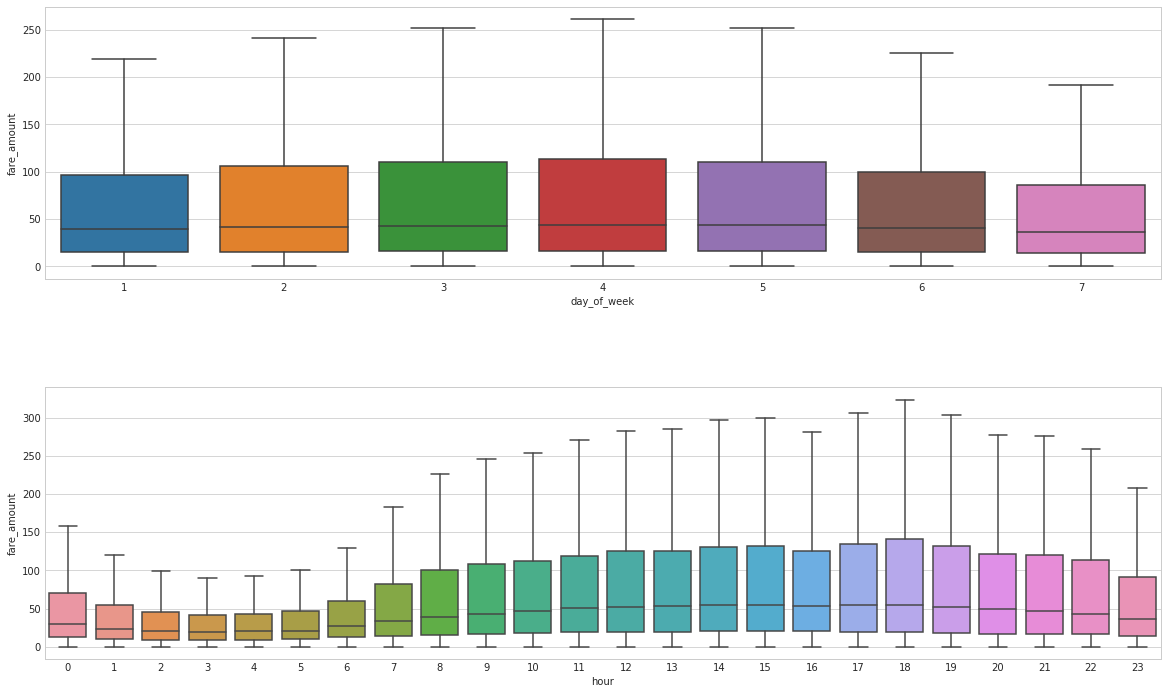

In [16]:

time_features = ['day_of_week', 'hour']

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(time_features)):
    ax = fig.add_subplot(2, 1, i+1)
    sns.boxplot(x=time_features[i], y="fare_amount", data=df_all[df_all['day_of_year'] >= 0], showfliers=False)

plt.show()

In [17]:
from sklearn.model_selection import train_test_split

train_v, test_v = train_test_split(df_all, test_size=0.2)

In [30]:
df_all.shape

(0, 20)

In [22]:
train_v.shape

(9710450, 10)

In [18]:
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker import get_execution_role
import boto3
from datetime import datetime
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [19]:
#train = train_v.copy()
#test = test_v.copy()

train_v.to_csv('train_small.csv', header=False, index=False)
test_v.to_csv('validate_small.csv', header=False, index=False)


In [20]:
!aws s3 cp train_small.csv s3://trip-ny-test/train/train/train_small.csv
!aws s3 cp validate_small.csv s3://trip-ny-test/train/validate/validate_small.csv

upload: ./train_small.csv to s3://trip-ny-test/train/train/train_small.csv
upload: ./validate_small.csv to s3://trip-ny-test/train/validate/validate_small.csv


In [42]:
!aws s3 cp validate_small.csv s3://trip-ny-test/train/validate/validate_small.csv

upload: ./validate_small.csv to s3://trip-ny-test/train/validate/validate_small.csv


In [23]:
path_train = os.path.join('train','train')
path_val = os.path.join('train','validate')
bucket = 'trip-ny-test'

In [24]:
container = get_image_uri(boto3.Session().region_name, 'xgboost', '1.0-1')
's3://{}/{}'.format(bucket, path_train)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


's3://trip-ny-test/train/train'

In [25]:
s3_input_trains3_inpu  = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_train),
                                            content_type='csv',
                                            distribution='ShardedByS3Key')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}'.format(bucket, path_val),
                                         content_type='csv', 
                                         distribution='ShardedByS3Key')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [26]:
sess = sagemaker.Session()
role = get_execution_role()

In [27]:
training_job_path = os.path.join('training_jobs', datetime.now().strftime('%Y-%m-%d-%H-%M-%S'))

In [28]:
xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket,training_job_path),
                                    sagemaker_session=sess)

In [29]:
's3://{}/{}/output'.format(bucket,training_job_path)

's3://trip-ny-test/training_jobs/2020-06-08-13-12-18/output'

In [30]:
xgb.set_hyperparameters(max_depth=9,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=300,
                        subsample=0.8,
                        silent=0,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=10000)

In [ ]:
xgb.fit({'train': s3_input_trains3_inpu, 'validation': s3_input_validation})

2020-06-08 13:13:23 Starting - Starting the training job...
2020-06-08 13:13:26 Starting - Launching requested ML instances......
2020-06-08 13:14:39 Starting - Preparing the instances for training...
2020-06-08 13:15:13 Downloading - Downloading input data...
2020-06-08 13:15:40 Training - Downloading the training image.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[13:16:00] 9710450x9 matrix with 87394050 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV 

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [56]:
from sagemaker.predictor import csv_serializer

In [57]:
df_test = pd.read_csv('./validate_small.csv', header=None)

In [59]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(df_test.values()[:, 1:])
predictions

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
df_val = pd.DataFrame()
df_val['prediction'] = predictions
df_val['target'] = df_test[0]

In [ ]:
plt.figure(figsize=(15,6))
sns.regplot(x=df_val["target"], y=df_val["prediction"])
plt.show()

In [ ]:
df_val['err'] = (df_val["target"] - df_val["prediction"])
df_val['err'].plot(kind='hist', bins=100, range=(-6,10), alpha=0.8, figsize=(15,6))
plt.show()

In [ ]:
df_val.describe()

In [ ]:
df_sample = df_test.loc[0:199]
feature_names = list(df_small.columns[1:])
feature_names

In [ ]:
df_sample.columns = feature_names
df_sample = df_sample.iloc[:, 1:]
explainer = shap.KernelExplainer(predict,df_sample.as_matrix())

In [ ]:
shap_values = explainer.shap_values(df_sample.as_matrix(), nsamples=100)
HBox(children=(FloatProgress(value=0.0, max=200.0), HTML(value='')))


In [ ]:
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names[1:])


In [ ]:
shap.summary_plot(shap_values, df_sample)